In [ ]:
#|default_exp branch_datasets
import numpy as np
import matplotlib.pyplot as plt

# datasets

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

from autometric.utils import plot_3d, plot_3d_with_geodesics

%load_ext autoreload
%autoreload 2

# 0d1 Branching Datasets
> The great serpentine branches - here they come!

TO test autometric, we need datasets. Specifically, we need datasets which are hard to embed but easy to understand - while, crucially, still being possible to embed in 2 dimensions. The sphere is out. The torus is out. Any complicated 2 manifold with nontrivial curvature is out. All this leaves is 1-manifolds, of which there is only one: the branch.

This, friends, is not an ordinary branch dataset. Nosiree! It's the mother of all branches. It lives natively in an arbitrary number of dimensions, and contains an arbitrary number of branching points. It's even annotated with this number of branching points. Our hope is that the autometrics of an embedding trained to various penalties reveal this number, or other yet-to-be-configured stata about this dataset.

THe branch is constructed in two repeating pieces.
1. a branch segment (or stick) is constructed at the origin from a randomly sampled polynomial stretching through time t in a random direction. The polynomial is returned with the end point.
2. This is translated to the end of one branch point, coursely sampled  and concatenated to the existing set of points. Then, a new number of branch points is chosen at this end, and the process repeats.

In [ ]:
#|export
import sympy as sp
import numpy as np
import itertools

def random_polynomial(
        vars, # variables to construct polynomial from
        degree = 2, # maximum degree of terms
        scale = 1, # scale of the polynomial coefficients (sampled from 0 to 1, multiplied by this)
):
    num_variables = len(vars)
    terms = []
    for d in range(1, degree + 1):
        for indices in itertools.combinations_with_replacement(range(num_variables), d):
            terms.append(np.prod([vars[i] for i in indices]))
    coeffs = np.random.uniform(size = len(terms))*scale
    return sum([coeffs[i] * terms[i] for i in range(len(terms))])


In [ ]:
#|export
from fastcore.all import *
import sympy as sp
import scipy.integrate

class Stick():
    def __init__(
        self,
        dimension,
        degree,
        starting_point,
        time_range = 1
    ):
        store_attr()
        # construct a unique polynomial for yourself
        x = sp.symbols('x')
        self.x = x
        p = random_polynomial(
            [x],degree
        )
        self.polynomial = p
        self.polynomial_np = sp.lambdify([x], self.polynomial, "numpy")
        self.starting_point = starting_point

        # random direction for polynomial, scaled to unit length
        self.direction = np.random.randn(self.dimension)
        self.direction /= np.linalg.norm(self.direction)

    def sample_at_time(self,t):
        return self.polynomial_np(self.direction*t) + self.start_point()

    def end_point(self):
        return self.sample_at_time(self.time_range)
    def start_point(self):
        return self.starting_point

    def sample(self, n_samples):
        ts = np.random.rand(n_samples)*self.time_range
        Xs = [self.sample_at_time(t) for t in ts]
        return np.array(Xs)
    
    # def length(self):
    #     l = -1
    #     i = 0
    #     while l < 0 and i < 100:
    #         l = self._length()
    #         print(l, 'at time', i, 'with polynomial', self.polynomial)
    #         i += 1
    #     return l
        
        
    # def length(self):
    #     # integrate the polynomial over the time range
    #     # using sympy
    #     x = sp.symbols('x')
    #     # path length integrand
    #     integrand = sp.sqrt(1 + sp.diff(self.polynomial, x)**2)
    #     integral = integrand.integrate()
        
    #     integral = sp.N(sp.integrate(
    #         integrand, (x, 0, self.time_range), 
    #         ))
    #     integral_fn = sp.lambdify([x], integral, "numpy")
    #     integrated_length = integral_fn(self.time_range)
    #     print('integrated length is',integral, 'numpy version is',integrated_length)
    #     return integrated_length
    
    def length(self):
        # Using these numerical methods is SO much faster than using sympy
        df_dx = sp.diff(self.polynomial, self.x)
        f_prime = sp.lambdify(self.x, df_dx, 'numpy')

        # Step 4: Define the function to integrate to find the curve length
        def integrand(x):
            return np.sqrt(1 + f_prime(x)**2)

        # Step 5: Calculate the curve length over a specified interval, e.g., from x = 0 to x = 1
        a, b = 0, self.time_range
        curve_length, _ = scipy.integrate.quad(integrand, a, b)

        return curve_length

2.0755627167349595


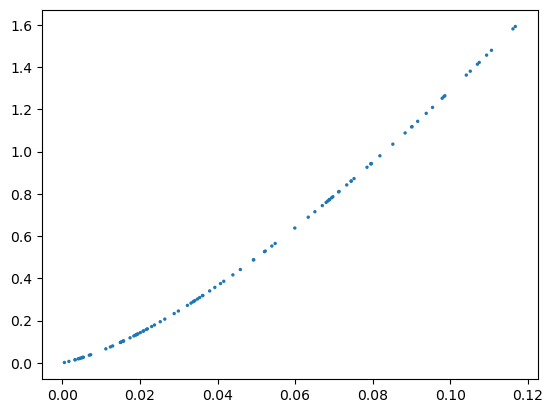

In [ ]:
# create a stick and test the sampling
stick = Stick(2,3,np.array([0,0]))
Xs = stick.sample(100)
plt.scatter(Xs[:,0],Xs[:,1],np.ones(100)*stick.length())
print(stick.length())

In [ ]:
stick = Stick(4,3,np.array([0,0]))
sp.diff(stick.polynomial)

2.55153861463027*x**2 + 1.69872706208064*x + 0.821183216249728

In [ ]:
#|export
import random
import numpy as np
import torch
import networkx as nx

class Branch():
    def __init__(
        self,
        dimension,
        polynomial_degree=2,
        max_branches=3,
        path_length = 5,
        num_samples = 2000,
        seed = None,
    ):
        store_attr()
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)

        self.sticks = [
            Stick(
                dimension,
                polynomial_degree,
                np.zeros(dimension)
            )
        ]
        self.branching_nums = [np.random.randint(2,max_branches)]
        
        
        # create a networkx graph
        self.G = nx.Graph()
        # add the first stick
        self.G.add_node(0)

        stick_idx = 0
        for i in range(path_length):
            # go through all sticks after stick_idx and create new sticks at their ends
            new_stick_idx =len(self.sticks)
            for j in range(stick_idx,len(self.sticks)):
                num_new_sticks = self.branching_nums[j]
                for k in range(num_new_sticks):
                    # create a stick
                    stick = Stick(
                        dimension,
                        polynomial_degree,
                        self.sticks[j].end_point(),
                    )
                    self.sticks.append(stick)
                    self.branching_nums.append(
                        np.random.randint(2,max_branches)
                    )
                    # add a node to the graph
                    self.G.add_node(len(self.sticks)-1)
                    # add an edge between the idx of the previous stick and the idx of the new stick
                    # j is the previous stick, since this is the end point; len(self.sticks)-1 is the new stick since it's the last stick
                    self.G.add_edge(j, len(self.sticks)-1)
                    
            stick_idx = new_stick_idx
        self.branching_nums = np.array(self.branching_nums)
        self.X = self.sample(num_samples)
        self.X_ground_truth = self.X

    def sample(self,n_samples=5000):
        self.num_branches_per_point = []
        self.branch_lengths = []
        self.samples_to_sticks = []
        
        Xs = []
        samples_per_stick = n_samples // len(self.sticks)
        for i, stick in enumerate(self.sticks):
            Xs.append(np.vstack([stick.sample(samples_per_stick-1),stick.end_point()]))
            self.num_branches_per_point.append(np.append(np.zeros(n_samples-1), self.branching_nums[i]))
            self.branch_lengths.append(
                np.ones(samples_per_stick)*stick.length()
            )
            self.samples_to_sticks.append(np.ones(samples_per_stick)*i)
        self.num_branches_per_point = np.concatenate(self.num_branches_per_point)
        self.branch_lengths = np.concatenate(self.branch_lengths)
        self.samples_to_sticks = np.concatenate(self.samples_to_sticks)
        return np.concatenate(Xs,axis=0)
    
    def pairwise_geodesic(self, a:np.ndarray, b:np.ndarray, ts):
        # check that both a and b are in self.X
        # find the distance between each point in self.X and a and then b
        dists_to_a = np.linalg.norm(self.X - a, axis=1)
        dist, idx_a = np.min(dists_to_a, axis=0), np.argmin(dists_to_a, axis=0)
        assert dist < 1e-3, f"Not sampled point. Distance between {a} and {self.X[idx_a]} is {dist}"
        dists_to_b = np.linalg.norm(self.X - b, axis=1)
        dist, idx_b = np.min(dists_to_b, axis=0), np.argmin(dists_to_b, axis=0)
        assert dist < 1e-3, f"Not sampled point. Distance between {b} and {self.X[-dx_b]} is {dist}"
        
        a_stick_idx = self.samples_to_sticks[idx_a]
        b_stick_idx = self.samples_to_sticks[idx_b]
        
        # get a djikstra path from a_stick_idx to b_stick_idx with self.G
        path = nx.shortest_path(self.G, a_stick_idx, b_stick_idx)
        path = list(path)# a list of stick idxs.
        path = [int(p) for p in path]
        if len(path) == 1:
            # both points are on the same stick. We approximate the geodesic as the stick. # TODO: restrict stick length to be less than the distance between the two points
            length = self.sticks[path[0]].length()
            return self.sticks[path[0]].sample(len(ts)), length
        
        # get distance from a to the closest endpoint of the path - closest to the next stick, that is. 
        # this is the same as the distance from a to the starting point of the next stick.
        starting_dist = np.linalg.norm(
            self.sticks[path[1]].start_point() - a
        )
        ending_dist = np.linalg.norm(
            self.sticks[path[-2]].end_point() - b
        )
        intermediate_dists = [self.sticks[p].length() for p in path[1:-1]]
        length = starting_dist + np.sum(intermediate_dists) + ending_dist
        
        # get the points along the path. We'll just sample new points along each of the intermediate sticks. 
        # For the starting and ending stick, we'll sample points and reject those which are further from the nearest stick than a and b respectively.
        def num_samples_per_length(partial_length):
            l =  int((partial_length / length) * len(ts))
            if l == 0: l = 1
            return l
        def num_points_so_far(points):
            return sum([len(p) for p in points])

        points = []
        starting_samples = self.sticks[path[0]].sample(num_samples_per_length(starting_dist))
        # reject points which are further from the next stick than a
        starting_samples = starting_samples[np.linalg.norm(starting_samples - self.sticks[path[1]].start_point(), axis=1) <= starting_dist]
        points.append(starting_samples)
        ending_samples = self.sticks[path[-1]].sample(num_samples_per_length(ending_dist))
        ending_samples = ending_samples[np.linalg.norm(ending_samples - self.sticks[path[-2]].end_point(), axis=1) < ending_dist]
        points.append(ending_samples)

        # if there are more than 2 sticks, here we sample intermediate points
        if len(path) > 2:
            for p, partial_length in zip(path[1:-2], intermediate_dists[:-1]):
                # get the points on the stick
                n = num_samples_per_length(partial_length)
                if n < 10: n = 10
                stick_points = self.sticks[p].sample(n)
                points.append(stick_points)
            # for the last intermediate stick, we'll supplement the samples to get the desired length
            num_samples = num_samples_per_length(intermediate_dists[-1]) + (len(ts) - num_samples_per_length(intermediate_dists[-1]) - num_points_so_far(points))
            if num_samples < 2: 
                num_samples = 2
            stick_points = self.sticks[path[-2]].sample(num_samples)
            points.append(stick_points)
        else:
            # to fill in the geodesic to desired length, we'll just repeatedly sample from start and end
            while num_points_so_far(points) < len(ts):
                points_left = (len(ts) - num_points_so_far(points)) // 2 + 1
                starting_samples = self.sticks[path[0]].sample(points_left)
                starting_samples = starting_samples[np.linalg.norm(starting_samples - self.sticks[path[1]].start_point(), axis=1) <= starting_dist]
                points.append(starting_samples)
                ending_samples = self.sticks[path[-1]].sample(points_left)
                ending_samples = ending_samples[np.linalg.norm(ending_samples - self.sticks[path[-2]].end_point(), axis=1) < ending_dist]
                points.append(ending_samples)
        
        # if len(points) exceeds len(ts), randomly subsample
        g = np.concatenate(points)
        if len(g) > len(ts):
            g = g[:len(ts)]
        if len(g) != len(ts):
            raise ValueError(f"Geodesic length is not equal to number of timesteps, with {len(g)} points and {len(ts)} timesteps and {len(path)} path points")
        return g, length
    
    def geodesics(self, start_points, end_points, ts):
        """
        Takes start, endpoint pairs in ambient space, and list of times. Returns geodesics and lengths.
        """
        # test if start and end points are tensors
        if isinstance(start_points, np.ndarray):
            start_points = torch.tensor(start_points)
        if isinstance(end_points, np.ndarray):
            end_points = torch.tensor(end_points)
        if isinstance(ts, np.ndarray):
            ts = torch.tensor(ts)
        
        # test if start and end points are among the previously sampled points
        # for each point, find the closest point in the sampled points. If it exceeds a threshold of 1e-3, then raise an error.
        distances_to_sampled_points = torch.cdist(torch.cat([start_points, end_points], dim=0), torch.tensor(self.X))
        corresponding_idxs = torch.argmin(distances_to_sampled_points, dim=1)
        
        for i in range(len(start_points)):
            # closest_idx = torch.argmin(distances_to_sampled_points[i], dim=0)
            closest_value = distances_to_sampled_points[i][corresponding_idxs[i]]
            if closest_value > 1e-3:
                raise ValueError(f"Start and end points must be among the previously sampled points. Min dist to manifold is {closest_value}")
            
        gs = []
        lengths = []
        for i in range(len(start_points)):
            g, l = self.pairwise_geodesic(start_points[i].numpy(), end_points[i].numpy(), ts)
            gs.append(torch.tensor(g))
            lengths.append(torch.tensor(l))
            
        # make conversion safe
        lengths = torch.tensor(lengths)
        gs = [g.cpu().detach() for g in gs]
        lengths = lengths.cpu().detach()
        return gs, lengths
        
        
        

In [ ]:
branch = Branch(3, path_length=4, seed = 480851)
Xs = branch.X
plot_3d(Xs,branch.branch_lengths,use_plotly=True)

In [ ]:
g, l = branch.pairwise_geodesic(Xs[0], Xs[1000], np.linspace(0,1,1000))

In [ ]:
plot_3d_with_geodesics(Xs, [g])

In [ ]:
# take two random subsets of Xs
start_points = Xs[np.random.choice(range(len(Xs)), size=(100), replace=False)]
end_points = Xs[np.random.choice(range(len(Xs)), size=(100), replace=False)]
gs, ls = branch.geodesics(start_points, end_points, np.linspace(0,1,1000))

In [ ]:
poly = branch.sticks[-3].polynomial
poly

0.691678488406875*x**2 + 0.705147816656849*x

In [ ]:
branch.sticks[-3].length()

1.0034472808169497

In [ ]:
branch.sticks[-2].length()

1.7607670123034718

In [ ]:
branch.sticks[0].start_point

<bound method Stick.start_point of <__main__.Stick object>>

In [ ]:
branch.num_branches_per_point

array([0., 0., 0., ..., 0., 0., 2.])

In [ ]:
branch.branch_lengths[2].shape

()

# Branch Battery Dataset

Here we create the 'Branch Battery', a collection of branches with a variable number of sticks, branching points, and dimensions. The purpose: to see how the autometrics of various embeddings can capture this ground truth information about the branches. For reproducibility across embedding techniques, we save the battery to disk.

Here's the format: a dictionary (saved in h5 format with DeepDISH!) containing keys

- samples: the sampled points
- dim: the ambient dimension of the branch
- branching_nums: a list of integers corresponding to the number of branches at the end of each stick.
- num_branches_per_point: a list of size len(samples) assigning, to each point, the number of branches that come out of that point.
- num_sticks: # sticks in branch
- max_branches: The maximum number of branches that can occur at any junction
- path_length: Number of branching events that occur

In [ ]:
# #|export
# from tqdm.auto import tqdm
# import h5py

# def create_branch_battery(
#     dimensions,
#     num_samples,
#     max_branches,
#     path_lengths,
#     num_branches_per_config,
#     outfile,
# ):
#     if os.path.exists(outfile):
#         return h5py.File(outfile,'a')
#     f = h5py.File(outfile,'a')
#     BIGLIST = []
#     for d in tqdm(dimensions):
#         for n in num_samples:
#             for m in max_branches:
#                 for p in path_lengths:
#                     for i in range(num_branches_per_config):
#                         branch = Branch(dimension=d, max_branches=m, path_length=p)
#                         X = branch.sample(n)
#                         # save this information to an h5py datafile
#                         branch_group = f.create_group(f"branch_{d}_{n}_{m}_{p}_{i}")
#                         samples = branch_group.create_dataset("samples", X.shape, dtype='f')
#                         samples[...] = X
#                         branches_per_point = branch_group.create_dataset("num_branches_per_point", branch.num_branches_per_point.shape, dtype='f')
#                         branches_per_point[...] = branch.num_branches_per_point
#                         branching_nums = branch_group.create_dataset("branching_nums", branch.branching_nums.shape, dtype='f')
#                         branching_nums[...] = branch.branching_nums
#                         branch_lengths = branch_group.create_dataset("branch_lengths", branch.branch_lengths.shape, dtype='f')
#                         branch_lengths[...] = branch.branch_lengths
#                         # add metadata to the group
#                         branch_group.attrs['num_sticks'] = len(branch.sticks)
#                         branch_group.attrs['num_samples'] = n
#                         branch_group.attrs['max_branches'] = m
#                         branch_group.attrs['path_length'] = p
#                         branch_group.attrs['dimension'] = d
#     return f


First, a simple test to ensure the function works.

In [ ]:
# dimensions = [3,4]
# num_samples = [1000]
# max_branches = [3,5]
# path_lengths = [2,3]
# num_branches_per_config = 2
# BBtest = create_branch_battery(
#     dimensions,
#     num_samples,
#     max_branches,
#     path_lengths,
#     num_branches_per_config,
#     outfile = '../data/test3.h5'
# )

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
list(BBtest.keys())

['branch_3_1000_3_2_0',
 'branch_3_1000_3_2_1',
 'branch_3_1000_3_3_0',
 'branch_3_1000_3_3_1',
 'branch_3_1000_5_2_0',
 'branch_3_1000_5_2_1',
 'branch_3_1000_5_3_0',
 'branch_3_1000_5_3_1',
 'branch_4_1000_3_2_0',
 'branch_4_1000_3_2_1',
 'branch_4_1000_3_3_0',
 'branch_4_1000_3_3_1',
 'branch_4_1000_5_2_0',
 'branch_4_1000_5_2_1',
 'branch_4_1000_5_3_0',
 'branch_4_1000_5_3_1']

In [ ]:
BBtest['branch_3_1000_3_2_0'].attrs['num_sticks']

3

In [ ]:
BBtest['branch_3_1000_3_2_0']['samples'][...]

array([[-1.153241  ,  0.91492903,  0.45275804],
       [-0.45087013,  0.3495144 ,  0.17580439],
       [-0.95242435,  0.7814308 ,  0.38614172],
       ...,
       [-2.641357  ,  0.5525822 , -0.01799229],
       [-2.6207247 ,  0.5571907 , -0.01432251],
       [-3.2375    ,  0.42398927, -0.12025297]], dtype=float32)

Now we create the battery file, after first checking to make sure the file doesn't already exist.

In [ ]:
# import os
# # params for battery
# dimensions = [2,3,4,5,8]
# num_samples = [5000]
# max_branches = [3,5,8]
# path_lengths = [2,3,4]
# num_branches_per_config = 10

# # check if the path data/branch_battery.h5 exists
# outfile = '../data/branch_battery.h5'
# if not os.path.exists(outfile):
#     # if not, create it
#     BB = create_branch_battery(
#         dimensions,
#         num_samples,
#         max_branches,
#         path_lengths,
#         num_branches_per_config,
#         outfile = outfile
#     )

  0%|          | 0/5 [00:00<?, ?it/s]

Finally, we'll provide a utility to make loading branches from the battery as PyTorch datasets really easy. It'll be a generic iterable.

In [ ]:
# #|export
# import h5py
# class BranchBattery():
#     def __init__(self, data_path = "../data/branch_battery.h5"):
#         self.data_path = data_path
#         self.BB = h5py.File(data_path,'r')
#         self.keys = list(self.BB.keys())
#     def __iter__(self):
#         return self
#     def __next__(self):
#         if len(self.keys) == 0:
#             raise StopIteration
#         else:
#             key = self.keys.pop()
#             return self.BB[key]